In [28]:
%pip install pandas scikit-learn openpyxl
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
%pip show scikit-learn pandas

Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: 
Author: 
Author-email: 
License: 
Location: c:\Python\Python311\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 
---
Name: pandas
Version: 2.3.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: 
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

 Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
 All rights reserved.

 Copyright (c) 2011-2023, Open source contributors.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the 

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df = pd.read_excel('smart_lighting_dataset_2024(1).csv.xlsx', engine='openpyxl')

print(df.head())
print(df.info())

            timestamp  zone_id  ambient_light_lux  motion_detected  \
0 2024-01-01 00:00:00        3               0.00                0   
1 2024-01-01 00:43:00        3              35.78                0   
2 2024-01-01 01:27:00        7               0.00                0   
3 2024-01-01 02:11:00        2               0.00                1   
4 2024-01-01 02:55:00        4               0.00                1   

   temperature_celsius  occupancy_count day_of_week time_of_day  \
0                22.08                7      Monday       Night   
1                19.19                6      Monday       Night   
2                27.78                9      Monday       Night   
3                33.11               16      Monday       Night   
4                27.07               11      Monday       Night   

  weather_condition  special_event_flag  energy_price_per_kwh  \
0            Cloudy                   0                  3.83   
1            Cloudy                   0       

In [48]:

# AUTO FEATURE (User Preference): data from sensors continuosly collected into database (sql?) and then exported to csv/xlsx for training
from sklearn.ensemble import GradientBoostingRegressor

features = [
    'ambient_light_lux', 'motion_detected', 'occupancy_count',
    'day_of_week', 'weather_condition',
    'prev_hour_energy_usage_kwh'
]
target = 'adjusted_light_intensity'

# Drop rows with any missing values
# Filter out unwanted rows before encoding and training
# Remove only rows where BOTH ambient_light_lux > 3500 AND adjusted_light_intensity > 66
df_clean = df.dropna()
df_clean = df_clean[~((df_clean['ambient_light_lux'] > 3500) & (df_clean['adjusted_light_intensity'] > 66))]

# Continue with encoding and modeling
df_encoded = pd.get_dummies(df_clean[features])
X = df_encoded
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = GradientBoostingRegressor(n_estimators=52, max_depth=4, random_state=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print("RMSE:", rmse)


# Example: Calculate multiplier for current brightness
current_brightness = 0  # Example value
recommended = model.predict(X_test.iloc[[1]])[0]
print(X_test.iloc[1])
print(X_test.iloc[2])
print(X_test.iloc[3])
multiplier = recommended / current_brightness
flat_change = recommended - current_brightness
print('Recommended:', recommended)
print('Multiplier:', multiplier)
print('Flat change:', flat_change)

RMSE: 10.30388081552612
ambient_light_lux             9920.71
motion_detected                     0
occupancy_count                     9
prev_hour_energy_usage_kwh       0.17
day_of_week_Friday               True
day_of_week_Monday              False
day_of_week_Saturday            False
day_of_week_Sunday              False
day_of_week_Thursday            False
day_of_week_Tuesday             False
day_of_week_Wednesday           False
weather_condition_Clear         False
weather_condition_Cloudy         True
weather_condition_Foggy         False
weather_condition_Rainy         False
Name: 9120, dtype: object
ambient_light_lux             6722.72
motion_detected                     0
occupancy_count                     3
prev_hour_energy_usage_kwh       0.48
day_of_week_Friday              False
day_of_week_Monday              False
day_of_week_Saturday             True
day_of_week_Sunday              False
day_of_week_Thursday            False
day_of_week_Tuesday             False


C:\Users\austi\AppData\Local\Temp\ipykernel_5064\2764999918.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = recommended / current_brightness


In [32]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': list(range(50, 151)),         # 50 to 150 (inclusive)
#     'max_depth': [None] + list(range(1, 31)),     # None and 1 to 30
#     'min_samples_split': list(range(2, 16))       # 2 to 15 (inclusive)
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# rmse = mean_squared_error(y_test, y_pred) ** 0.5
# print("RMSE:", rmse)
# #maxdepth 5, minsplit 14, nestimator 99 is best running above. rmse of 10.30791000918946

In [49]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Grid search for Random Forest
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [10]
}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Grid search for Gradient Boosting
gb_param_grid = {
    'n_estimators': [99],
    'max_depth': [5]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=3, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

# Stacking ensemble with best models
base_models = [
    ('rf', best_rf),
    ('gb', best_gb)
 ]
meta_model = LinearRegression()
stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking.fit(X_train, y_train)

# Predict and evaluate stacking ensemble
y_pred_stack = stacking.predict(X_test)
stack_rmse = mean_squared_error(y_test, y_pred_stack) ** 0.5
print('Stacking RMSE:', stack_rmse)

Stacking RMSE: 10.363857101053847


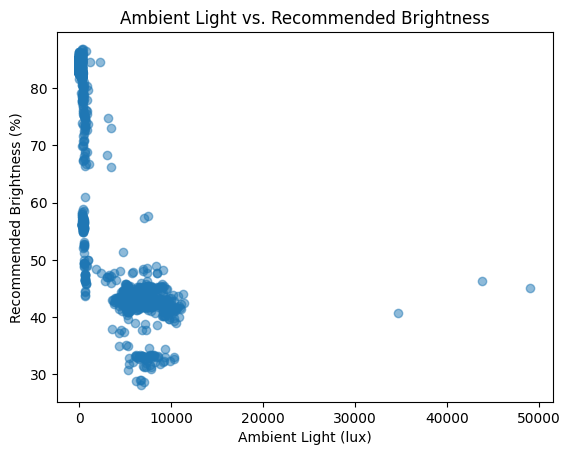

In [50]:
# Visualize relationship between ambient light and recommended brightness
import matplotlib.pyplot as plt

# Use test set for visualization
ambient_light = X_test['ambient_light_lux'] if 'ambient_light_lux' in X_test.columns else None
recommended_brightness = y_pred if 'y_pred' in locals() else None

if ambient_light is not None and recommended_brightness is not None:
    plt.scatter(ambient_light, recommended_brightness, alpha=0.5)
    plt.xlabel('Ambient Light (lux)')
    plt.ylabel('Recommended Brightness (%)')
    plt.title('Ambient Light vs. Recommended Brightness')
    plt.show()
else:
    print('Could not find ambient_light_lux in X_test or y_pred in scope.')

DecisionTreeRegressor RMSE: 10.389996955349552


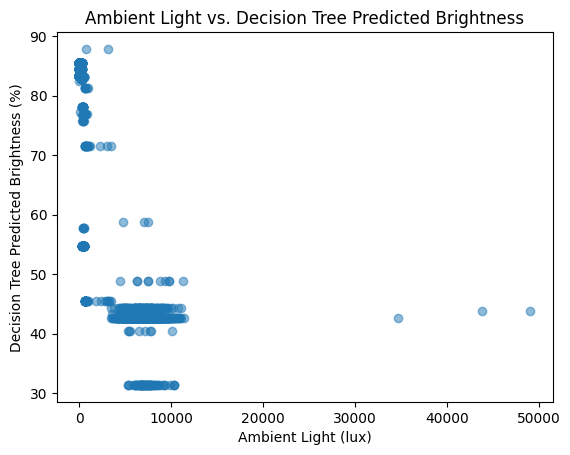

In [51]:
# Train and evaluate a Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
dt_rmse = mean_squared_error(y_test, y_pred_dt) ** 0.5
print('DecisionTreeRegressor RMSE:', dt_rmse)

# Visualize Decision Tree predictions
import matplotlib.pyplot as plt
ambient_light = X_test['ambient_light_lux'] if 'ambient_light_lux' in X_test.columns else None
if ambient_light is not None:
    plt.scatter(ambient_light, y_pred_dt, alpha=0.5)
    plt.xlabel('Ambient Light (lux)')
    plt.ylabel('Decision Tree Predicted Brightness (%)')
    plt.title('Ambient Light vs. Decision Tree Predicted Brightness')
    plt.show()
else:
    print('Could not find ambient_light_lux in X_test.')

In [ ]:
# Ensemble: Stacking Regressor with best models
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=52, max_depth=4, random_state=5)),
    ('gb', GradientBoostingRegressor(n_estimators=52, max_depth=4, random_state=5)),
    ('dt', DecisionTreeRegressor(max_depth=4, random_state=5)),
    
]

# Meta-model
meta_model = LinearRegression()

# Stacking ensemble
stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking.predict(X_test)
stack_rmse = mean_squared_error(y_test, y_pred_stack) ** 0.5
print('Stacking Ensemble RMSE:', stack_rmse)

Stacking Ensemble RMSE: 10.304577685416705


In [37]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


XGBoost RMSE: 10.381027215397012


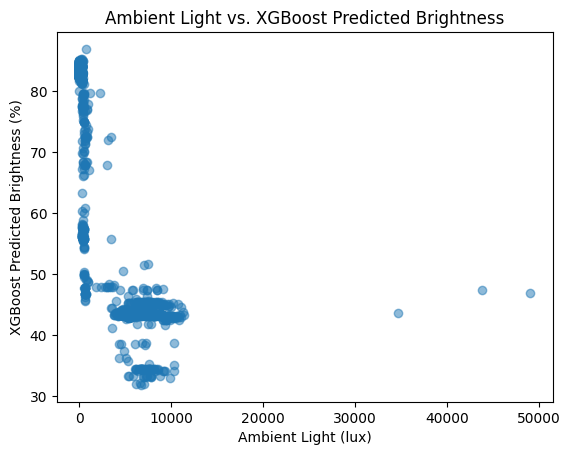

In [38]:
# Train and evaluate XGBoost Regressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(n_estimators=63, max_depth=4, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5
print('XGBoost RMSE:', xgb_rmse)

# Visualize XGBoost predictions
import matplotlib.pyplot as plt
ambient_light = X_test['ambient_light_lux'] if 'ambient_light_lux' in X_test.columns else None
if ambient_light is not None:
    plt.scatter(ambient_light, y_pred_xgb, alpha=0.5)
    plt.xlabel('Ambient Light (lux)')
    plt.ylabel('XGBoost Predicted Brightness (%)')
    plt.title('Ambient Light vs. XGBoost Predicted Brightness')
    plt.show()
else:
    print('Could not find ambient_light_lux in X_test.')

In [39]:
# Define base models including XGBoost
base_models = [
    ('rf', RandomForestRegressor(n_estimators=52, max_depth=4, random_state=5)),
    ('gb', GradientBoostingRegressor(n_estimators=52, max_depth=4, random_state=5)),
    ('xgb', XGBRegressor(n_estimators=63, max_depth=4, learning_rate=0.05, random_state=42)),
]

# Meta-model
meta_model = LinearRegression()

# Stacking ensemble
stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking.predict(X_test)
stack_rmse = mean_squared_error(y_test, y_pred_stack) ** 0.5
print('Stacking Ensemble (with XGBoost) RMSE:', stack_rmse)

Stacking Ensemble (with XGBoost) RMSE: 10.307586831691621


In [40]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
df = pd.read_excel('smart_lighting_dataset_2024(1).csv.xlsx', engine='openpyxl')

features = [
    'ambient_light_lux', 'motion_detected', 'occupancy_count',
    'day_of_week', 'weather_condition', 'special_event_flag',
    'prev_hour_energy_usage_kwh'
]
target = 'adjusted_light_intensity'

# Drop rows with any missing values
# Filter out unwanted rows before encoding and training
# Remove only rows where BOTH ambient_light_lux > 3500 AND adjusted_light_intensity > 66
df_clean = df.dropna()
df_clean = df_clean[~((df_clean['ambient_light_lux'] > 3500) & (df_clean['adjusted_light_intensity'] > 66))]

# Continue with encoding and modeling
df_encoded = pd.get_dummies(df_clean[features])
X = df_encoded
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Predict and evaluate
y_pred_nn = model.predict(X_test_scaled).flatten()
print('y_test shape:', y_test.shape)
print('y_pred_nn shape:', y_pred_nn.shape)
from sklearn.metrics import mean_squared_error
nn_rmse = mean_squared_error(y_test, y_pred_nn) ** 0.5
print('Keras NN RMSE:', nn_rmse)

Epoch 1/200


c:\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4001.0823 - mae: 58.4359 - val_loss: 364.9570 - val_mae: 15.3965
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 350.2424 - mae: 14.6116 - val_loss: 215.1307 - val_mae: 11.3647
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 305.5900 - mae: 13.0128 - val_loss: 199.9275 - val_mae: 10.9251
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 275.6743 - mae: 12.8042 - val_loss: 192.8678 - val_mae: 10.7211
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 257.3708 - mae: 12.3216 - val_loss: 190.9840 - val_mae: 10.8027
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 252.5434 - mae: 12.4043 - val_loss: 184.9308 - val_mae: 10.4718
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 249.4551 - mae: 12.2955 - val_loss: 184.5502 - val_mae: 10.5390
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 249.2330 - mae: 12.1217 - val_loss: 180.6242 - val_mae: 10.3651
Epoch 9/200